# Fake News Classifier using  Bidirectional LSTM

 __dataset link :__ https://www.kaggle.com/c/fake-news/data

### About dataset :

train.csv: A full training dataset with the following attributes:
        
1. id: unique id for a news article
2. title: the title of a news article
3. author: author of the news article
4. text: the text of the article; could be incomplete
5. label: a label that marks the article as potentially unreliable. Where 1: unreliable and 0: reliable.


## 1.
#### importing libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud

#### 1.2 Loading the dataset

In [2]:
df = pd.read_csv("train.csv")

In [3]:
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


#### 1.3 checking the missing values

In [4]:
df.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

- In given data there are some missing values . Firstly we have to avoid the missing values.

####  1.4 Dropping the missing values

In [5]:
df = df.dropna() #  removing the missing values rows from dataset

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18285 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      18285 non-null  int64 
 1   title   18285 non-null  object
 2   author  18285 non-null  object
 3   text    18285 non-null  object
 4   label   18285 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 857.1+ KB


- Now we don't have any null values.So we can go for the next step.

####  1.5 checking duplicates

In [7]:

duplicateRowsDF = df[df.duplicated(["id","title","author","text"], keep="last")]
print("No of duplicates found:", duplicateRowsDF.shape[0])



#removing duplicates
# final_data = df.drop_duplicates(["id","title","author","text"], keep="first", inplace=False)

No of duplicates found: 0


 #### 1.6  wordcloud

- It will show the most frequent word in the given text.
- Most frequent word becomes larger & darker.

In [8]:
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\9875013747\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [9]:
stop_words = set(stopwords.words("english"))

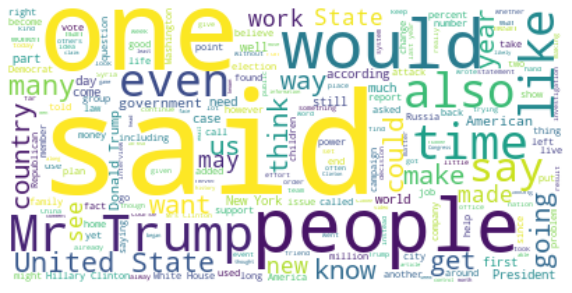

In [10]:
text = " ".join([x for x in df.text])
wordcloud = WordCloud(background_color = 'white', stopwords = stop_words).generate(text)
plt.figure(figsize = (10,8))
plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

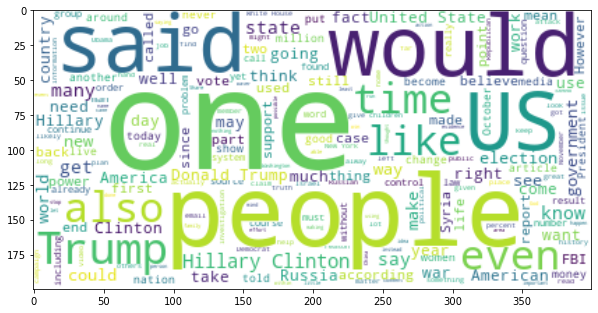

In [11]:
### for fake news 

text = " ".join([x for x in df.text[df.label == 1]])
wordcloud = WordCloud(background_color = 'white', stopwords = stop_words).generate(text)
plt.figure(figsize = (10,8))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.show()

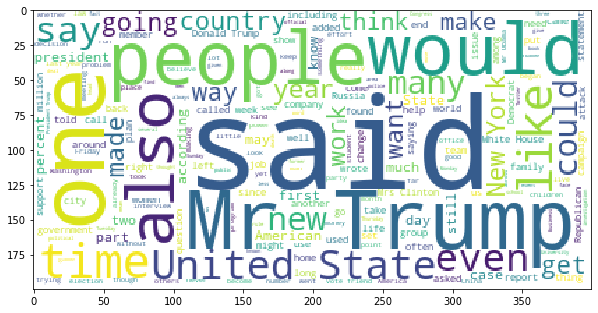

In [12]:
### for Not fake (real)

text = " ".join([x for x in df.text[df.label == 0]])
wordcloud = WordCloud(background_color = 'white',  stopwords = stop_words).generate(text)
plt.figure(figsize = (10,8))
plt.imshow(wordcloud)

#### 1.7 Independent Features & dependent Features

In [13]:
X = df.drop('label',axis = 1)

In [14]:
### dependent Features
y = df['label']

In [15]:
X.shape

(18285, 4)

In [16]:
y.shape

(18285,)

#### 1.8  checking balance or imbalance dataset

In [17]:
print('Number of 0 (not fake) :', df['label'].value_counts()[0])
print('Number of 1 (fake) :', df['label'].value_counts()[1])

Number of 0 (not fake) : 10361
Number of 1 (fake) : 7924


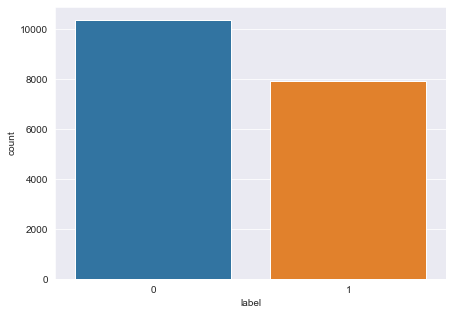

In [18]:
sns.set_style('darkgrid')
plt.figure(figsize=(7,5))
sns.countplot(x='label',data=df)

## 2.  Data preprocessing

When we are dealing with text data, first we need to preprocess the text and then convert it into vectors.

- Stemming is actually removing the suffix from a word and reducing it to its root word. First use stemming technique on text to convert into its root word.

- We generally get text mixed up with a lot of special characters,numerical, etc. we need to take care of removing unwanted text from data. Use regular expressions to replace all the unnecessary data with spaces

- Convert all the text into lowercase to avoid getting different vectors for the same word . Eg: and, And ------------> and

- Remove stopWords - “stop words” typically refers to the most common words in a language, Eg: he, is, at etc. We need to filter stopwords.
  1. Split the sentence into words
  2. Extract the text except for stopwords
  3. Again join them into sentences
  4. Append the cleaned text into a list (corpus)
  
  
Now our text is ready , convert the text into vectors 



In [19]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional

In [20]:
### voc size
voc_size  = 5000

In [21]:
messages = X.copy()

In [22]:
messages.reset_index(inplace = True)

#### 2.1 applying  Stemming 

In [23]:

from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
corpus = []
for i in range(0, len(messages)):
    review = re.sub('[^a-zA-Z]', ' ', messages['title'][i])  ### apart form a-z&A-Z replace(:,*:;) with ' '
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)


In [24]:
corpus[0] # list of sentences after stemming

'hous dem aid even see comey letter jason chaffetz tweet'

#### 2.2 One hot representation

In [25]:
onehot_repr = [one_hot(words, voc_size) for words in corpus]
onehot_repr[0]

[2880, 2758, 801, 4672, 2545, 2747, 4376, 760, 736, 541]

- Here we created the one_hot representation converted all sentence into vector.
-  But they are not fixed size.For that we have to apply  __pre padding__.

#### 2.3  pre- padding 

In [26]:
# pre padding to create same size of sentences.

sent_length = 25
embedded_doc = pad_sequences(onehot_repr,padding = 'pre', maxlen= sent_length)


In [27]:
embedded_doc[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0, 2880, 2758,  801, 4672, 2545, 2747, 4376,
        760,  736,  541])

- here clearly we can see that in that above sentence we added the 0 in the starting of that particular sentence by using __pre padding__.similarly for all 
sentences.Now the sentences have same size.

##  3 Modeling

#### 3.1 Model Building

In [28]:
from tensorflow.keras.layers import Dropout
### creating model
embedding_vector_features = 40
model = Sequential()
model.add(Embedding(voc_size,embedding_vector_features, input_length = sent_length))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(100)))
model.add(Dropout(0.3))
model.add(Dense(1,activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 40)            200000    
_________________________________________________________________
dropout (Dropout)            (None, 25, 40)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               112800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 201       
Total params: 313,001
Trainable params: 313,001
Non-trainable params: 0
_________________________________________________________________


In [29]:
X_final = np.array(embedded_doc)
y_final = np.array(y)

In [30]:
X_final.shape

(18285, 25)

#### 3.2  splitting data into train and validate set

In [31]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train, y_test = train_test_split(X_final, y_final, test_size = 0.20, random_state = 42)

#### 3.3 model training

In [32]:
model_history = model.fit(X_train,y_train, validation_data = (X_test,y_test), epochs = 5, batch_size  =64)

Train on 14628 samples, validate on 3657 samples
Epoch 1/5
14628/14628 [==============================] - 30s 2ms/sample - loss: 0.3046 - accuracy: 0.8522 - val_loss: 0.2021 - val_accuracy: 0.9114
Epoch 2/5
14628/14628 [==============================] - 14s 965us/sample - loss: 0.1459 - accuracy: 0.9409 - val_loss: 0.2179 - val_accuracy: 0.9158
Epoch 3/5
14628/14628 [==============================] - 15s 1ms/sample - loss: 0.1070 - accuracy: 0.9607 - val_loss: 0.2398 - val_accuracy: 0.9139
Epoch 4/5
14628/14628 [==============================] - 16s 1ms/sample - loss: 0.0752 - accuracy: 0.9726 - val_loss: 0.2870 - val_accuracy: 0.9125
Epoch 5/5
14628/14628 [==============================] - 16s 1ms/sample - loss: 0.0566 - accuracy: 0.9815 - val_loss: 0.3100 - val_accuracy: 0.9109


##  4. Performance Metrics and Accuracy

In [33]:
y_pred = model.predict_classes(X_test)


In [34]:
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report
cm  = confusion_matrix(y_test, y_pred)

print(accuracy_score(y_test, y_pred),'\n')
print(classification_report(y_test, y_pred))

0.9108558928083128 

              precision    recall  f1-score   support

           0       0.93      0.91      0.92      2082
           1       0.88      0.92      0.90      1575

    accuracy                           0.91      3657
   macro avg       0.91      0.91      0.91      3657
weighted avg       0.91      0.91      0.91      3657



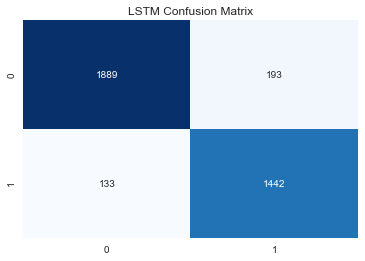

In [35]:
plt.title('LSTM Confusion Matrix')
sns.heatmap(cm,annot = True, cbar = False, fmt="d",cmap="Blues")

## 5.  Applying Model on test dataset

####  5.1 loading test dataset for prediction



In [36]:
test_df = pd.read_csv('test.csv')


In [37]:
test_df.head()

,id,title,author,text
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning..."
1,20801,Russian warships ready to strike terrorists ne...,NaN,Russian warships ready to strike terrorists ne...
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different..."
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...


- Here we don't have predicted values(label) in test_df

#### 5.2  checking  null values in the test_df & handling 

In [38]:


test_df.isnull().sum()

id          0
title     122
author    503
text        7
dtype: int64

- here we have null values in test_df. We have to handle the null values.

In [39]:
test_df.fillna('fake fake fake',inplace=True)


In [40]:
test_df.shape

(5200, 4)

####  5.3 creating corpus for the test_df exactly the same as we created for the training dataset

In [41]:


corpus_test = []
for i in range(0, len(test_df)):
    review = re.sub('[^a-zA-Z]', ' ',test_df['title'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus_test.append(review)

####  5.4 creating one hot representation for the test corpus


In [42]:

onehot_repr_test=[one_hot(words,voc_size)for words in corpus_test] 

#### 5.5  padding for the test dataset

In [43]:

sent_length=25

embedded_docs_test=pad_sequences(onehot_repr_test,padding='pre',maxlen=sent_length)
print(embedded_docs_test)

[[   0    0    0 ... 4252 1486  828]
 [   0    0    0 ...  266 3326 4092]
 [   0    0    0 ... 1793  353 2211]
 ...
 [   0    0    0 ... 4252 1486  828]
 [   0    0    0 ... 3760  316 3326]
 [   0    0    0 ... 4252 1486  828]]


In [44]:
X_test=np.array(embedded_docs_test)

####  5.6 making predictions for the test dataset

In [45]:


check = model.predict_classes(X_test)

In [46]:
check

array([[0],
       [1],
       [0],
       ...,
       [0],
       [1],
       [0]])

#### 5.7  adding predicted label to test dataset

In [47]:
test_df['label'] = check

In [48]:
test_df

,id,title,author,text,label
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning...",0
1,20801,Russian warships ready to strike terrorists ne...,fake fake fake,Russian warships ready to strike terrorists ne...,1
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...,0
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different...",0
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...,1
...,...,...,...,...,...
5195,25995,The Bangladeshi Traffic Jam That Never Ends - ...,Jody Rosen,Of all the dysfunctions that plague the world’...,0
5196,25996,John Kasich Signs One Abortion Bill in Ohio bu...,Sheryl Gay Stolberg,WASHINGTON — Gov. John Kasich of Ohio on Tu...,0
5197,25997,"California Today: What, Exactly, Is in Your Su...",Mike McPhate,Good morning. (Want to get California Today by...,0
5198,25998,300 US Marines To Be Deployed To Russian Borde...,fake fake fake,« Previous - Next » 300 US Marines To Be Deplo...,1


## 6. Conclusion :

- Here we made a classifier using LSTM which can detect the news is fake or not.